In [15]:
import warnings
warnings.filterwarnings("ignore")

import readPlotOptionSurface
import modulesForCalibration as mcf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#Parametri (estratti da bloomberg)
alpha = 1.5
eta = 0.2

n = 12

#Scelta del Modello
model = "Heston"

#AAPL (estratto da bloomberg per quello specifico giorno)
r = 0.0245
q = 0.005
S0 = 190.3

In [3]:
#Finding a starting point
#Heston params = (kappa, teta, lambda, rho, vu0)
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)


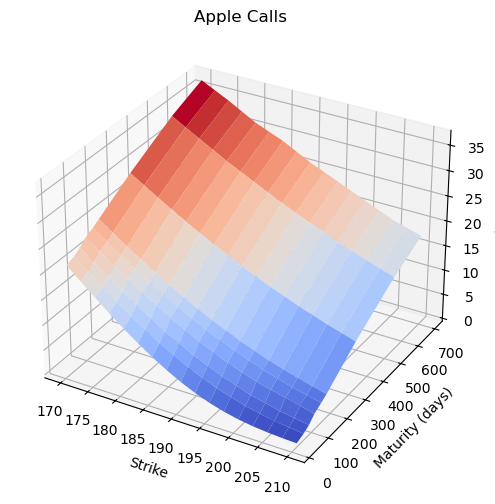

In [4]:
iArray = []
rmseArray = []
rmseMin = 1e10

maturities, strikes, callPrices = readPlotOptionSurface.readNPlot()

marketPrices = callPrices
maturities_years = maturities/365

In [5]:
#Creo l'interpolazione per diverse i (alfa) ottengo diverse combinazioni di parmas1 e parmas2

for i in mcf.myRange(0, 1, 0.05):
    params = i*np.array(params1) + (1.0-i)*np.array(params2)

    #Per ogni combinazione ottengo un dato parmas(i) che userò per calcolare il prezzo delle call
    iArray.append(i)

    try:
        #Ad ogni prezzoCall(i) calcolo il RMSE(i) 
        rmse = mcf.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model) 

        rmseArray.append(rmse)
        if (rmse < rmseMin):
            rmseMin = rmse
            optimParams = params

    except Exception as e:
        print(f"errore durante il calcolo per i={i}: {e}")
        iArray.pop()


#Stampo lo starting point
print(rmseMin)
print(optimParams)


0.8658939945597864
[ 2.3     0.046   0.0825 -0.53    0.054 ]


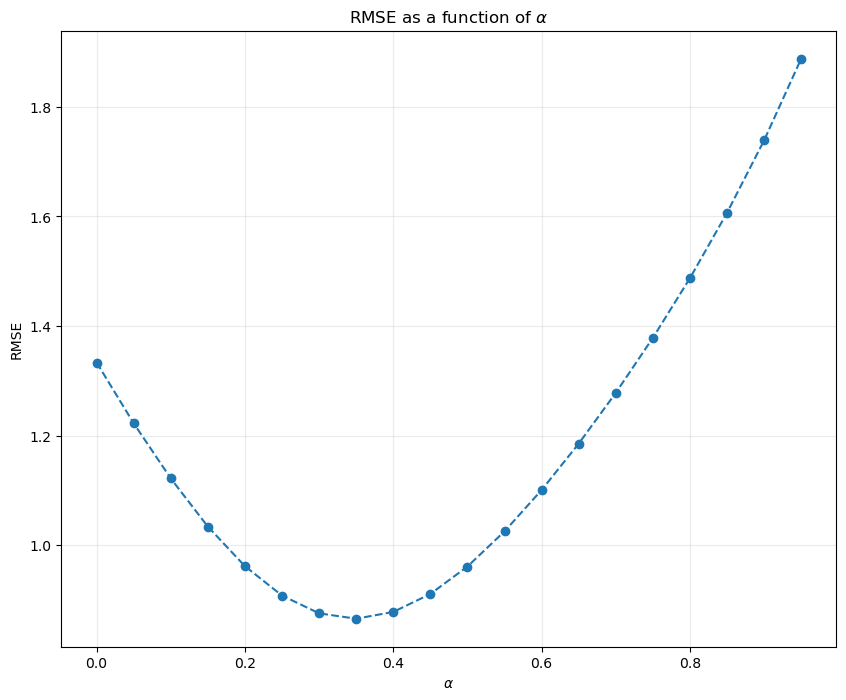

In [6]:
#Plotto la superficie di H
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, "o--")
plt.grid(alpha=0.25)
plt.xlabel("$\\alpha$")
plt.ylabel("RMSE")
plt.title("RMSE as a function of $\\alpha$")

plt.show()

In [12]:
#Optimization routine
#strarting point: [ 2.3     0.046   0.0825 -0.53    0.054 ]
ind_iter = 1
rsmeMin = 1.0e6

#BRUTE FORCE
for kappa in mcf.myRange(1.8, 2.3, 0.5):
    for theta in mcf.myRange(0.036, 0.046, 0.01):
        for sig in mcf.myRange(0.0825, 0.0925, 0.01):
            for rho in mcf.myRange(-0.63, -0.53, 0.1):
                for v0 in mcf.myRange(0.044, 0.054, 0.01):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)

                    print("i = "+ str(ind_iter))
                    ind_iter +=1
                    print(params)
                    rmse = mcf.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print("\nnew min found")
                        print(rmseMin)
                        print(params2)
                        print(" ")

print("\Solution of Brute force search:")
print(params2)
print("Optimal RMSE: "+ str(rmseMin))
                    

i = 1
[1.8, 0.036, 0.0825, -0.63, 0.044]
i = 2
[1.8, 0.036, 0.0825, -0.63, 0.054]
i = 3
[1.8, 0.036, 0.0825, -0.53, 0.044]
i = 4
[1.8, 0.036, 0.0825, -0.53, 0.054]
i = 5
[1.8, 0.036, 0.0925, -0.63, 0.044]
i = 6
[1.8, 0.036, 0.0925, -0.63, 0.054]
i = 7
[1.8, 0.036, 0.0925, -0.53, 0.044]
i = 8
[1.8, 0.036, 0.0925, -0.53, 0.054]
i = 9
[1.8, 0.046, 0.0825, -0.63, 0.044]

new min found
0.3731389881401168
[1.8, 0.046, 0.0825, -0.63, 0.044]
 
i = 10
[1.8, 0.046, 0.0825, -0.63, 0.054]
i = 11
[1.8, 0.046, 0.0825, -0.53, 0.044]
i = 12
[1.8, 0.046, 0.0825, -0.53, 0.054]
i = 13
[1.8, 0.046, 0.0925, -0.63, 0.044]

new min found
0.36704126063686315
[1.8, 0.046, 0.0925, -0.63, 0.044]
 
i = 14
[1.8, 0.046, 0.0925, -0.63, 0.054]
i = 15
[1.8, 0.046, 0.0925, -0.53, 0.044]
i = 16
[1.8, 0.046, 0.0925, -0.53, 0.054]
i = 17
[2.3, 0.036, 0.0825, -0.63, 0.044]
i = 18
[2.3, 0.036, 0.0825, -0.63, 0.054]
i = 19
[2.3, 0.036, 0.0825, -0.53, 0.044]
i = 20
[2.3, 0.036, 0.0825, -0.53, 0.054]
i = 21
[2.3, 0.036, 0.0925

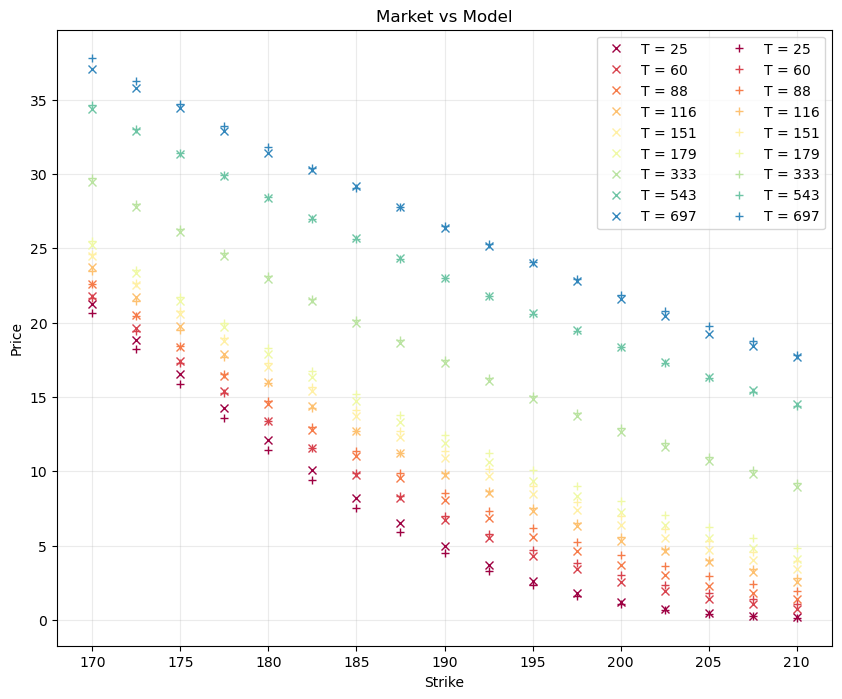

In [19]:
#Plotto Model vs Market
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mcf.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i, j] = cT_km[0]

#plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
colors = [colormap(i) for i in np.linspace(0, 0.9, lenT)]
plt.gca().set_prop_cycle(color=colors)
for i in range(lenT):
    plt.plot(strikes, callPrices[i, :], "x")
    labels.append("T = " + str(maturities[i]))

for i in range(lenT):
    plt.plot(strikes, modelPrices[i, :], "+")
    labels.append("T = " + str(maturities[i]))

plt.legend(labels, loc="best", ncol=2)
plt.grid(alpha=0.25)
plt.xlabel("Strike")
plt.ylabel("Price")
plt.title("Market vs Model")
plt.show()
                                 